# Prerequsites

In [1]:
# log the time of the experiment
from datetime import datetime
import time

exp_time = datetime.now()
exp_time_str = exp_time.strftime("_%H_%M_%S")
date_str = exp_time.strftime("%m_%d_%y")

In [2]:
# Path management for MacOS and Windows
from pathlib import Path
import os, sys

scriptPath = Path(sys.path[0])
parentPath = Path(sys.path[0]).parent
#libPath = Path("/home/tw329/GitHub/ONN_MNIST/")
libPath = Path("C:\\Users\\Logan\\Documents\\GitHub\\ONN_MNIST")
sys.path.append(libPath.as_posix())
sys.path.append("C:\\Users\\Logan\\Documents\\GitHub\\mcmahon_lab_devices") 

# Set the working directory (to save the files)
resultPath = scriptPath

slmWeightPath = resultPath / "slm_weights"
if not os.path.exists(slmWeightPath.as_posix()):
    os.makedirs(slmWeightPath.as_posix())
    
phoneImagePath = resultPath / "phone_images"
if not os.path.exists(phoneImagePath.as_posix()):
    os.makedirs(phoneImagePath.as_posix())
    
saveDataPath = resultPath / "saved_data"
if not os.path.exists(saveDataPath.as_posix()):
    os.makedirs(saveDataPath.as_posix())
    
print(resultPath)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC


In [3]:
from __future__ import print_function
import os, sys
import argparse
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
%matplotlib notebook

# Instrument Controls

In [5]:
# Configure the SLM
from src.slmpy import SLMdisplay   # Popoff's simple package for controlling SLM

slm = SLMdisplay(isImageLock = True)

LUT_used="AmpLUT_basedon_100120slmbackcali_140509_start5.lut"

slmParamFile = resultPath / ''.join(["slm_info", exp_time_str, ".txt"])
with open(slmParamFile,'w') as slmparams:
    slmparams.write('LUT\t\t\t{}\n'.format(LUT_used))
slmparams.close()


C:/Users/Logan/Documents/GitHub/ONN_MNIST\src\slmpy.py:39: wxPyDeprecationWarning: Call to deprecated item EmptyImage. Use :class:`Image` instead.
  self.img = wx.EmptyImage(2,2)


In [6]:
import pyvisa
from devices import Agilent54845A as AgilentOscope

rm = pyvisa.ResourceManager("C:\\WINDOWS\\System32\\visa64.dll")
gpib_id = rm.list_resources()[-1]
oscope = AgilentOscope(rm.open_resource(gpib_id))
oscope.set_waveform_source(1)

def oscope_info(oscope):
    measure_state = {}
    measure_state["ID"] = oscope.id()
    measure_state["x_range"] = oscope.get_xrange()
    measure_state["x_unit"] = oscope.get_xunits()
    measure_state["y_range"] = oscope.get_yrange()
    measure_state["y_unit"] = oscope.get_yunits()
    measure_state["y_offset"] = oscope.get_offset()
    measure_state["y_bounds"] = [oscope.get_bottom_bound(), oscope.get_top_bound()]
    return measure_state

In [7]:
# Configure the phone

from Android_Display_Control.Remote_Display.image_stream import AndroidOpenAccessoryBridge as AOAB

PIXEL_VENDOR_ID = 0x18d1
PIXEL_UNCONFIG_ID =  0x4ee7
PIXEL_CONFIG_ID = 0x2d01

# Create an AOAB object for managing data send/receive via USB
aoab = AOAB(PIXEL_VENDOR_ID, PIXEL_UNCONFIG_ID, 
  PIXEL_CONFIG_ID,
  manufacturer='ImageStreamManufacturer',
  model='ImageStream1',
  description='Stream Images to Android',
  version=1,
  uri=('https://github.com/chris-blay/android-open-accessory-bridge'),
  serial='AoabSerial')

Exception ignored in: <function _AutoFinalizedObjectBase.__del__ at 0x0000018CD55C5C80>
Traceback (most recent call last):
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 84, in __del__
    self.finalize()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 144, in finalize
    self._finalizer()
  File "C:\Users\Logan\Anaconda3\lib\weakref.py", line 552, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 104, in _do_finalize_object_ref
    obj._do_finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 71, in _do_finalize_object
    self._finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _finalize_object
    _lib.libusb_unref_device(self.devid)
OSError: exception: access violation writing 0x0000000000000024


In [8]:
def PIL_to_bytestream(img_px):
    array_px = np.array(img_px)
    byte_array_px = bytearray()

    for i in range(array_px.shape[0]):
        for j in range(array_px.shape[1]):
            byte_array_px.append(array_px[i, j, 0])
            byte_array_px.append(array_px[i, j, 1])
            byte_array_px.append(array_px[i, j, 2])

    assert(len(byte_array_px) == 1920*1080*3)
    return byte_array_px

In [9]:
# Load the phone pixel LUT
lut_p = torch.zeros(1000, dtype=torch.uint8) 
with open((resultPath/'PhoneLUT_100120_161444c30et20ms_1000.lut').as_posix(),'r') as lutfile:
        for i in range(len(lut_p)):
            aline = lutfile.readline().split()
            lut_p[i] = int(aline[1])
lutfile.close()

# Helper Functions

In [10]:
""" Helper functions for generating phone and SLM patterns. """

from math import sqrt

def Wrap_vec_to_square (idx_vec, null_element=torch.tensor([-1])):
    
    if isinstance(null_element, int):
        null_element = torch.tensor([null_element])
        
    a = int(sqrt(len(idx_vec)))
    if len(idx_vec) < a*(a+1):
        px_col_counts = a
        last_row_supplements = a - 1 - (idx_vec.numel()-1)%a 
    if len(idx_vec) >= a*(a+1):
        px_col_counts = a+1
        last_row_supplements = a - (idx_vec.numel()-1)%(a+1)
    
    idx_vec = torch.cat((idx_vec, torch.repeat_interleave(null_element, last_row_supplements)))
    idx_vec = idx_vec.view(-1, px_col_counts)
    
    return idx_vec

# Image binarize functions
def binarize_img_by_percentile(img, rate):
    img_b = (img<=np.percentile(img.numpy(), rate))
    res_ones = int(img_b.sum() - rate/100.0 * img_b.numel())
    vec_b = img_b.flatten()
    vec_b[vec_b.nonzero()[:res_ones]] = 0
    return vec_b.view(img_b.shape)

def add_surr(img,expan_r):
    img_shape = np.array(img.shape)
    expan_img = np.zeros(img_shape*expan_r)
    expan_img[expan_r//2::expan_r,expan_r//2::expan_r] = img
    return expan_img

def expand_pixels(img, expan_r):
    img_temp = torch.repeat_interleave(img, expan_r, dim=0)
    return torch.repeat_interleave(img_temp, expan_r, dim=1)

def Add_frame(pic, frame_px_value):
    
    frame = torch.zeros(pic.shape[0]+40, pic.shape[1]+40, dtype=pic.dtype)
    frame[[0,-1],:] = frame_px_value
    frame[:,[0,-1]] = frame_px_value
    frame[20:-20, 20:-20] = pic
    
    return frame

# Correction Mask

In [11]:
f_list = []
for f in os.listdir(saveDataPath):
    if f.endswith('.pkl'):
        f_list.append(f)
f_list

['phonemask_blk600x600_antiatt_phone_mask_onsite_lb640_1_1012_092948.bmp.pkl',
 'phonemask_blk600x600_antiatt_phone_mask_raw_1012_092948.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_raw_1015_233224.pkl']

In [12]:
def im_maxmin(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.title(f"max/min = {img.max():.1f}/{img.min():.1f} = {img.max()/img.min():.2f}")
    plt.xlabel(f"std/mean = {img.std():g}/{img.mean():g} = {img.std()/img.mean():g}")
    plt.show()

<IPython.core.display.Javascript object>


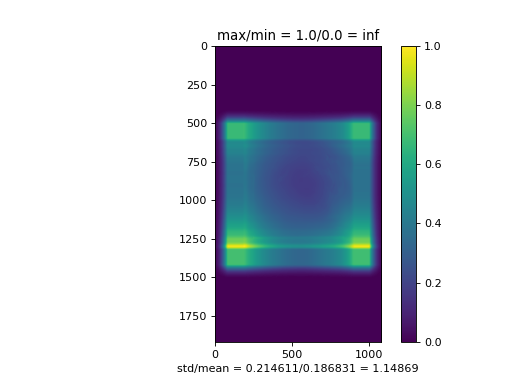

C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [13]:
import joblib
maskPath = saveDataPath
maskName = "phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl"
mask_str = "onsite"
# maskName = "blk600x600_antiatt_phone_mask_raw_0911_142600.bmp"
# mask_str = "rawmask"
phone_mask = joblib.load(saveDataPath / maskName)
# if len(mask.shape)==3:
#     mask = mask[:,:,1]
phone_mask
im_maxmin(phone_mask)

In [14]:
expan_r = 5
x_norm_expan = torch.repeat_interleave(torch.ones(28, 28), expan_r, dim=0)
x_norm_expan = torch.repeat_interleave(x_norm_expan, expan_r, dim=1)
x_norm_embedded = CenterEmbedding(x_norm_expan, torch.zeros(1920, 1080))
sub_phone_mask = phone_mask * x_norm_embedded.numpy()
sub_phone_mask = sub_phone_mask / sub_phone_mask.max()
plt.figure()
plt.imshow(sub_phone_mask)
plt.show()

NameError: name 'CenterEmbedding' is not defined

# Definition of the Neural Network

In [15]:
""" Define digitized fully connected layers """

# Definition of an in-place digitization function.
def Digitize(tensor, quant_mode='det', levels=16, min_val=None, max_val=None):
    if not min_val and not max_val:
        min_val, max_val = tensor.min().item(), tensor.max().item()
    tensor.clamp_(min_val, max_val).add_(-1*min_val).mul_(levels-1).div_(max_val-min_val)
    if quant_mode == "det": 
        tensor.round_()
    elif quant_mode == "rand":
        tensor.add_(torch.rand(tensor.size(), device=tensor.device).add_(-0.5)).round_()
    tensor.mul_(max_val-min_val).div_(levels-1).add_(min_val)
    return tensor

class DigitizeLinear(nn.Linear):

    def __init__(self,  *kargs, a_quant_mode="det", w_quant_mode="det", a_quant_levels=16, w_quant_levels=32, running_weight=0.001, **kwargs):
        super(DigitizeLinear, self).__init__(*kargs, **kwargs)
        self.act_quant_mode = a_quant_mode
        self.weight_quant_mode = w_quant_mode
        self.register_buffer("act_quant_levels", torch.tensor(a_quant_levels))
        self.register_buffer("weight_quant_levels", torch.tensor(w_quant_levels))
        self.register_buffer("running_weight", torch.tensor(running_weight)) 
        self.register_buffer("running_min", None)
        self.register_buffer("running_max", None)

    def forward(self, input):

        if not self.weight_quant_mode is None: # Set a flag to control weight digitization.
            if not hasattr(self.weight,'org'):
                self.weight.org=self.weight.data.clone()
            self.weight.data=Digitize(self.weight.data, quant_mode=self.weight_quant_mode, levels=self.weight_quant_levels)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()    
        out = nn.functional.linear(input, self.weight, bias=self.bias)

        if not self.act_quant_mode is None: # A flag to control output digitization. 
            if self.training: # Update the running average of min and max only during training
                with torch.no_grad():
                    if not self.running_min and not self.running_max:
                        self.running_min, self.running_max = out.min(), out.max()
                    self.running_min = (1-self.running_weight) * self.running_min + self.running_weight * out.min()
                    self.running_max = (1-self.running_weight) * self.running_max + self.running_weight * out.max()
            out.data=Digitize(out.data, quant_mode=self.act_quant_mode, levels=self.act_quant_levels, min_val=self.running_min, max_val=self.running_max)
    
        return out

In [16]:
""" Define a generic QAT MLP structure (including perceptron) """

class Net(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([DigitizeLinear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X
    
    def set_digitize_config(self, a_quant_mode, w_quant_mode, a_quant_levels, w_quant_levels):
        for fc in self.fcs:
            fc.act_quant_mode = a_quant_mode
            fc.weight_quant_mode = w_quant_mode
            fc.act_quant_levels = torch.tensor(a_quant_levels)
            fc.weight_quant_levels = torch.tensor(w_quant_levels)

In [17]:
""" Load the trained model """

device = "cpu"

model = Net([784, 100, 100, 10])
for l in model.fcs:
    l.running_min = torch.tensor(0.0)
    l.running_max = torch.tensor(0.0)
model_ckpt = torch.load("./RA_4bit_H2_100_100_lr_0.043_0.50_m_0.87_wep_6_randActDigi_v80_ep97.pt", map_location=device)
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

Net(
  (fcs): ModuleList(
    (0): DigitizeLinear(in_features=784, out_features=100, bias=True)
    (1): DigitizeLinear(in_features=100, out_features=100, bias=True)
    (2): DigitizeLinear(in_features=100, out_features=10, bias=True)
  )
)

In [18]:
""" Construct dataloaders """

trainID_range = range(200) # ID of the samples to be passed through the NN

# Import the test data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if True else {}

data_mnist_test = datasets.MNIST('../ML_data', 
                                 train=False, 
                                 transform=transforms.Compose([transforms.ToTensor()]))

# Remember to set the batch size to the length of train ID range, or the dataloader will draw sample one by one.
subset_data_loader = torch.utils.data.DataLoader(data_mnist_test, 
                                           batch_size=int(max(trainID_range)+1), 
                                           shuffle=False, **kwargs)

# Remember to set the batch size to the length of train ID range, or the dataloader will draw sample one by one.
test_loader = torch.utils.data.DataLoader(data_mnist_test, 
                                           batch_size=1, 
                                           shuffle=False,  **kwargs)

# Notes on ONN Forward Propagation Implementation (Rev. 3)

The update equation from one neuron layer to the next:

\begin{equation}
x_{i}^{L+1} = \sigma(\sum_{j}^N{W_{ij}^{L} x_{j}^{L}+b_i^{L}})    
\end{equation}

where $x_j^L$ is the activation of neuron $j$ in layer $L=0,1,..$.

Since the pixel values in an ONN are intensity encoded, including inputs, activations, and weights, the update equation needs to be modified such that the matrices and vectors to be loaded onto the ONN contain only non-negative numbers. In fact, the possible range of matrix and vector entries is actually limited to positive values, since the phone and SLM pixel values cannot infinitely approach zero in reality, due to hardware limitations. The following framework deals with the most general case where both phone and SLM pixel values cannot be extinguished to zero. If reality, if the resolution permits, the expression can be significantly simplified if either phone or SLM pixels can reach zero within the demanded accuracy.

The update equation is first rewritten into a vector form to facilitate the following discussion:

\begin{equation}
X^{L+1} = \sigma({W^{L} X^{L} + B^{L}})    
\end{equation}

A note on symbol convention: any lower case letter represents a column vector (e.g., $b$, $x$); any captital letter represents a matrix (e.g., $W$, and $X$ actually indicates a batch of data $X = [x_0, x_1, ..., x_{B-1}]$); columns and rows of a matrix is represented in Python indexing convention (i.e., $W[,j]$ and $W[i,]$); element at row $i$ and column $j$ of matrix $W$ is written as $W[i,j]$ instead of $W_{ij}$; the $i$th element in vector a vector is also indicated with Python indexing convention (e.g., $x[i]$ instead of $x_i$). The superscript $L$ indicating the layer of NN is dropped here and below as long as it does not cause any confusion. 

Therefore, $W^L[i,j]$ is the weight from neuron i in layer L to neuron j in layer L+1, $X^L[j,k]$ is the actication of neuron j of data batch index k, $B^L[i,k]$ is the bias for neuron i in layer L.

Each element in a row $W[i,]$ can be linearly mapped from interval $[\text{min}(W[i,]), \text{max}(W[i,])]$ to $[I_\text{min}, I_\text{max}]$, with $I_\text{max}>I_\text{min} \geq 0$. More explicitely, the resultant matrix $\tilde{W}$ is related to $W$ with the relation:

\begin{equation}
W = \hat{K}\tilde{W} + \hat{D}\mathbb{1}
\end{equation}

where
\begin{equation}
\hat{K}=\frac{1}{I_\text{max}-I_\text{min}}diag\{\Delta W_i = \text{max}(W[i,]) - \text{min}(W[i,])\}, 
\hat{D} = \frac{1}{I_\text{max}-I_\text{min}} diag \{I_\text{max} \text{min}(W[i,]) - I_\text{min} \text{max}(W[i,]) \}
\end{equation}
and $\mathbb{1}$ is all 1 matrix. (Tip: hat implies diagonal matrix; tilde implies the control signal to be sent to a device, such as phone or SLM).


The same transform can be performed on a data batch, which gives $X = \tilde{X} \hat{K}_X  +  \mathbb{1}\hat{D}_X$ ($\hat{K}_X$ and $X$ switch position because the definiation of $X$ is transposed from that of $W$.)

Now we can rewrite the update equation as
\begin{equation}
X^{L+1}  = \sigma( \hat{K}  \{\tilde{W} \tilde{X}^L\} \hat{K}_X  + \hat{D} \{\mathbb{1} \tilde{X}^L\} \hat{K}_X  + \hat{K} \{\tilde{W}\mathbb{1}\}\hat{D}_X + \hat{D} \mathbb{1}\mathbb{1} \hat{D}_X + b)
\end{equation}


Note that the matrix products in curly brackets are to be measured expiermentally from the ONN output, and the other quantities are computed once and stored.


The reason to rewrite the update equation in this form is to carry out *each* inner product computation at the full pixel resolution of the smartphone and SLM. The matrices and vectors are always normalized to cover the entire dynamic range of the devices. The normalization factor is stored and later re-applied to the value readout from the ONN to recover the actual numerical value. 


More specifically, the passing of NN activation from one layer to the next can be summarized as the following steps:
1. Normalize $W$ to $\tilde{W}$, which needs to be done only once for a trained NN and takes $O(MN)$ operations. 
2. Normalize $X$ to $\tilde{X}$, which needs to be done for every input and layer and takes a total of $NBL$ multiplications. However, these operations can be waived if the phone pixel has high enough bit depth. Since the activations are usually non-negative numbers, it is possible to represent them with pixel intensity without any pre-processing.
3. Load $\tilde{X}$ to the phone to control pixel intensity and $\tilde{W}$ to SLM to control transimission. In this way, $\tilde{W}$ and $\tilde{X}$ are both represented with the full resolutin of the devices.
4. Measure the total pixel value in a region of interest that corresponds to the inner product $\tilde{W}[i,]\tilde{X}[,j]$ (read: the input to neuron $i$ for the data batch index $j$) in the captured camera image. In the ideal case, this signal can be measured by a single-pixel detector.
5. Use the calibration model to find $\tilde{W}[i,]\tilde{X}[,j]$ based on the integrated pixel value in the regions of interest, obtained in step (4). 
6. After reading out all the entries of $\tilde{W}\tilde{X}$ (W_til_X_til), multiply it with $\hat{D}$ and $\hat{D_X}$ digitially, which were obtained in step (1) and (2).
7. Derive $\mathbb{1} \tilde{X}$ (sum_X_til) and $\tilde{W}\mathbb{1}$ (sum_W_til) following similar steps as (5) and (6). Essentially they are just special cases of $\tilde{W}\tilde{X}$ with either $\tilde{W} = \mathbb{1}$ or $\tilde{X} = \mathbb{1}$.
8. Add the computed terms $\hat{K}\tilde{W}\tilde{X}\hat{K}_X$ (Delta_W_Delta_X), $\hat{D}\mathbb{1}\tilde{X}\hat{K}_X$ (Offset_W_Delta_X),  $\hat{K}\tilde{W}\mathbb{1}\hat{D}_X$ (Delta_W_Offset_X), $\hat{D} \mathbb{1}\mathbb{1}\hat{D}_X$ (Offset_W_Offset_X), and $b$ digitally, and then apply the nonlinear activation function $\sigma$ to obtain the activations of neurons.



In [19]:
"""Auxilitary functions for simulating activation propation in ONN"""

def digitize(x, levels=8, min_val=None, max_val=None):
    """
    digitize activations into the discrete steps, by rounding to the closest level.
    levels: specifies the number of total discrete levels.
    min_val: the x value to be mapped to the lowest level
    max_val: the x value to be mapped to the highest level
    """

    if not min_val and not max_val:
        min_val, max_val = x.min(), x.max()
    x = (levels-1)*(x - min_val)/(max_val-min_val)
    x = x.round()
    x = torch.min(torch.max(x, torch.zeros_like(x)), torch.ones_like(x)*(levels-1))
    x = x*(max_val-min_val)/(levels-1) + min_val
    return x

def Matrix_Linear_Mapping(W, target_interval):
    """
    Transform each column of W with the following linear transform: 
    Argument target_interval=[a,b] specifies the lower and upper bound a and b.
    The minimum of each column of W will be mapped to a, and the maximum of each W column mapped to b.
    The rest of elements in the column are mapped in-between a and b with linear interporlation.
    Such operation is repeated for each column individually.
    """
    
    W = W.type(torch.double)
    W_mins, _ = torch.min(W, dim=0) 
    W_maxs, _ = torch.max(W, dim=0)
    Delta_I = float(target_interval[1] - target_interval[0])
    Delta_W = W_maxs - W_mins
    K_W = torch.diag(Delta_W/Delta_I)
    D_W = target_interval[1]*W_mins - target_interval[0]*W_maxs
    offset = torch.mm(torch.repeat_interleave(D_W.view(1,-1), W.shape[0],dim=0), torch.diag(1/Delta_W))
    W_til = torch.mm(W, torch.diag(Delta_I/Delta_W)) - offset
    
    return (W_til, K_W, torch.diag(D_W)/Delta_I)
    

def ONN_layer_prop(layer, W_transform, X_transform, W_digitize_func=None, X_digitize_func=None, Act_digitize_func=None,  X=None,
                     W_til_X_til=None, sum_W_til=None, sum_X_til=None):
    """
    Forward propagate a batch of data for one layer.

    layer: of type torch.nn.module, the layer to propagate the current batch of data through. Both W and b are derived from layer.
    W_transform: the mapping from the W stored in layer to the control value to be applied to SLM.
    X_transform: the mapping from the activation values stored in X to the control value to be applied to the smartphone.
    Act_digitize_func: The function for digitizing the output activation. No digitization is performed if None is given.
    W_digitize_func: The function for digitizing weight matrix W before the forward propagation. 
                     No digitization is performed if None is assigned to W_digitize_func as default.
    X_digitize_func: The function for digitizing the batch data X before the forward propagation. 
                     No digitization is performed if None is assigned to X_digitize_func as default.
    X: Inputs to the current NN layer. 
       If X is not given, an identity matrix is assigned to X as default, such that the W_til_X_til returned by the function equals W_til.
       X.shape = [batch size, current NN layer width]
    W: weight matrix derived from layer. W.shape = [current NN layer width, next NN layer size]
    b: bias vector. b.shape = [next NN layer width]
    
    When no digitization is performed on W, X, or Wx+b, only linear stretching is performed on W and X, and the output of the function is 
    almost identical to the results obtained by prop(layer).
    """
    
    W = layer.weight.data.t()
        
    # Normalize W 
    (W_til, K_W, D_W) = W_transform(W)
    
    if X is None: # If X is not given, make it an identity matrix.
        X = torch.eye(W.shape[0])
        (X_til, K_X, D_X) = Matrix_Linear_Mapping(X, [0,1])
    else: # Normalize X
        (X_til, K_X, D_X) = X_transform(X.t())
        (X_til, K_X, D_X) = (X_til.t(), K_X.t(), D_X.t())
    
    if W_digitize_func is not None:
        W_til = W_digitize_func(W_til)
        
    if X_digitize_func is not None:
        X_til = X_digitize_func(X_til)
        
    W_til_max = W_til[:,0].max()
    X_til_max = X_til[0,:].max()
    
    # First simulate the three measurables from the ONN (defined in Notes on ONN Forward Propagation Implementation (Rev. 3)):
    if W_til_X_til is None:
        W_til_X_til = torch.mm(X_til, W_til) # tilde{WX} 
    if sum_X_til is None:
        sum_X_til = torch.mm(X_til, torch.ones_like(W_til)) * W_til_max # sum(tilde{X[j,:]}), aka the sum of all activations of batch index j.   
    if sum_W_til is None:
        sum_W_til = torch.mm(torch.ones_like(X_til), W_til) * X_til_max# sum(tilde{W[:,i]}), aka the sum of all weights into neuron i.
    
    # The following terms are defined in Notes on ONN Forward Propagation Implementation (Rev. 3)
    Delta_W_Delta_X = torch.mm(torch.mm(K_X, W_til_X_til), K_W) 
    Delta_W_Offest_X = torch.mm(torch.mm(K_X, sum_X_til), D_W) / W_til_max
    Offset_W_Delta_X = torch.mm(D_X, torch.mm(sum_W_til, K_W)) / X_til_max
    Offset_W_Offset_X = torch.mm(D_X, torch.mm(torch.ones_like(W_til_X_til)*W_til.shape[0], D_W)) 
    
    Wx = Delta_W_Delta_X + Delta_W_Offest_X + Offset_W_Delta_X + Offset_W_Offset_X  # Wx
    Wx_b = Wx + torch.repeat_interleave(layer.bias.view(1,-1), W_til_X_til.shape[0], dim=0).type(torch.double) # Wx+b
    if Act_digitize_func is not None:
        Wx_b = Act_digitize_func(Wx_b) # digitize(Wx+b)
    a = F.relu(Wx_b) # ReLU(digitize(Wx+b))

    return {"norm(W)norm(X)": W_til_X_til, "sum(norm(X))": sum_X_til, "sum(norm(W))": sum_W_til, "Wx": Wx, "Wx+b": Wx_b, "a": a}

In [20]:
# Calculate the ground truth of activations of each layer 
# by Propagating each test sample through the trained NN and record activation of each layer.
import pandas

X, data_labels = next(iter(subset_data_loader))
X = X.view(X.size(0), -1)
X0 = X

df_layer = {}

# Define the transform and quantization functions for all layers:
W_transform = lambda W: Matrix_Linear_Mapping(W, [5,2**8-1])
X_transform = lambda X: Matrix_Linear_Mapping(X, [0,1000-1])
W_digitize = lambda W: Digitize(W.clone(), levels=2**8-5) # levels of quantization for W
X_digitize = lambda X: Digitize(X.clone(), levels=1000) # levels of quantization for X
# One very strange thing is that you cannot lambda function dictionary

for l, layer in enumerate(model.fcs):
    # Calculate the ground truth activation by passing through one layer
    layer.act_quant_mode=None
    layer.weight_quant_mode=None
    X0 = F.relu(layer(X0))
    
    # Propagate the batch for one layer
    Act_digitize = lambda X: Digitize(X.clone(), levels=2**4, min_val=layer.running_min.item(), max_val=layer.running_max.item()) # levels of quantization for y=Wx+b
    results = ONN_layer_prop(layer, W_transform, X_transform, \
                             W_digitize_func=W_digitize, X_digitize_func=X_digitize, Act_digitize_func=Act_digitize, X=X)    
    X = results["a"] # The activation of the current layer is the input to the next layer. 
    
    results["a_true"] = X0
    df = {}
    for k in results.keys():
        df[k] = pandas.DataFrame(results[k].detach().numpy()).stack(level=-1)
    df_layer[l] = pandas.concat(df, axis=1)
        
# Concatenate the df for each sample into an even larger one to include all the samples spcified.    
df_all_acts = pandas.concat(df_layer, axis=0, \
                            keys=df_layer.keys(), names=["layer", "test_ID", "output node"])
df_all_acts.index = df_all_acts.index.swaplevel(0,1)

In [21]:
df_all_acts

norm(W)norm(X)  sum(norm(X))  sum(norm(W))  \
test_ID layer output node                                               
0       0     0                 7435548.0    18435480.0   101575323.0   
              1                 9019478.0    18435480.0    99886014.0   
              2                 9160499.0    18435480.0    95635269.0   
              3                 9690888.0    18435480.0   101176722.0   
              4                11035015.0    18435480.0    94579326.0   
...                                   ...           ...           ...   
199     2     5                  596998.0     2243745.0    10846143.0   
              6                  604275.0     2243745.0     9649341.0   
              7                 1273638.0     2243745.0    10318671.0   
              8                 1021207.0     2243745.0    12271716.0   
              9                  682060.0     2243745.0    11444544.0   

                                   Wx        Wx+b          a      a_true  
test_ID layer output node                                                 
0       0     0            -15.719175  -15.587848   0.000000    0.000000  
              1             -3.035051   -1.576992   0.000000    0.000000  
              2             -1.905754   -1.576992   0.000000    0.000000  
              3              2.341606    5.428436   5.428436    2.607136  
              4             13.105385   12.433863  12.433863   12.107492  
...                               ...         ...        ...         ...  
199     2     5           -502.093804 -515.057654   0.000000    0.000000  
              6           -495.412649 -515.057654   0.000000    0.000000  
              7            119.142521   94.972668  94.972668  101.693199  
              8           -112.619283 -108.370772   0.000000    0.000000  
              9           -423.996730 -413.385933   0.000000    0.000000  

[42000 rows x 7 columns]

In [22]:
print(data_labels[50])
df_all_acts.loc[(50,0)]

tensor(6)


C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


,norm(W)norm(X),sum(norm(X)),sum(norm(W)),Wx,Wx+b,a,a_true
output node,,,,,,,
0,10328027.0,20142450.0,101575323.0,0.475091,-1.576992,0.000000,0.000000
1,10031575.0,20142450.0,99886014.0,-1.898899,-1.576992,0.000000,0.000000
2,11218257.0,20142450.0,95635269.0,7.604060,5.428436,5.428436,6.597994
3,11818030.0,20142450.0,101176722.0,12.407047,12.433863,12.433863,12.708588
4,9299017.0,20142450.0,94579326.0,-7.765229,-8.582420,0.000000,0.000000
...,...,...,...,...,...,...,...
95,8049976.0,20142450.0,105060834.0,-17.767560,-15.587848,0.000000,0.000000
96,9271061.0,20142450.0,97347555.0,-7.989101,-8.582420,0.000000,0.000000
97,10241632.0,20142450.0,106398495.0,-0.216761,-1.576992,0.000000,0.000000


# Generate Phone and SLM Images

The normalized weight matrix to be applied on the SLM looks like below:


<IPython.core.display.Javascript object>


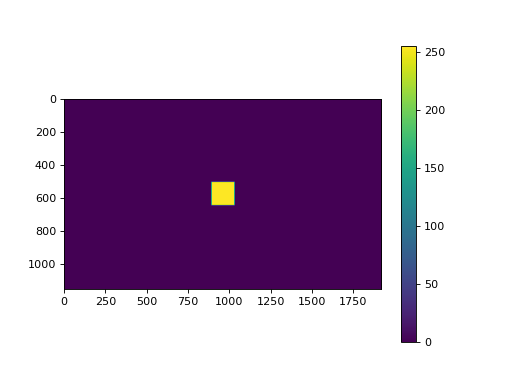

In [23]:
""" Generate the weight images to be applied to SLM and save them. """
# Pre-process the SLM weight matrix by shifting all elements to non-negative.

import numpy as np
from utils.helper_functions import ConvertPhoneImageToSLMImage, NormalizeWeights, CenterEmbedding

# Indicate the current NN layer (the 1st layer has index 0)
L = 0
expan_r = 5

# Convert weight matrix to SLM control values using EXACTLY the same sequence of functions as in ONN_layer_prop()
W = model.fcs[L].weight.data.t()
W_til,_,_ = W_transform(W)
W_norm = W_digitize(W_til).t()
W_norm = W_norm.round().type(torch.uint8)

slm_weights_numpy = {}

for i in range(W_norm.size(0)):
    # Add a frame for alignment, and embed in a canvas of phone display size
    w_norm_expan = torch.repeat_interleave(W_norm[i,:].view(28,-1), expan_r, dim=0)
    w_norm_expan = torch.repeat_interleave(w_norm_expan, expan_r, dim=1)
    w_norm_embedded = CenterEmbedding(w_norm_expan, torch.zeros(1920, 1080, dtype=torch.uint8))
    w_norm_slm = ConvertPhoneImageToSLMImage(w_norm_embedded, 1.0) # Convert the phone image to SLM image.

    # Save the SLM patterns to image files.
    w_norm_path = slmWeightPath / (f"SLM_MLP_{expan_r}x_fc{L}_w{i}.bmp")
    w_norm_slm.save(w_norm_path.as_posix(), format = 'bmp') # PIL.Image.save can be saved as 8-bit greyscale bmp

    
w_norm_embedded = CenterEmbedding(torch.ones_like(w_norm_expan)*255, torch.zeros(1920, 1080, dtype=torch.uint8))
w_norm_slm = ConvertPhoneImageToSLMImage(w_norm_embedded, 1.0) # Convert the phone image to SLM image.

# Save the SLM patterns to image files.
w_norm_path = slmWeightPath / (f"SLM_MLP_{expan_r}x_fc{L}_wsum.bmp")
w_norm_slm.save(w_norm_path.as_posix(), format = 'bmp') # PIL.Image.save can be saved as 8-bit greyscale bmp
    
# Plot w_kaleidoscope 
print("The normalized weight matrix to be applied on the SLM looks like below:")
fig, ax = plt.subplots()
im = ax.imshow(w_norm_slm)
fig.colorbar(im, ax=ax)
plt.show()

The normalized weight matrix to be applied on the SLM looks like below:


<IPython.core.display.Javascript object>


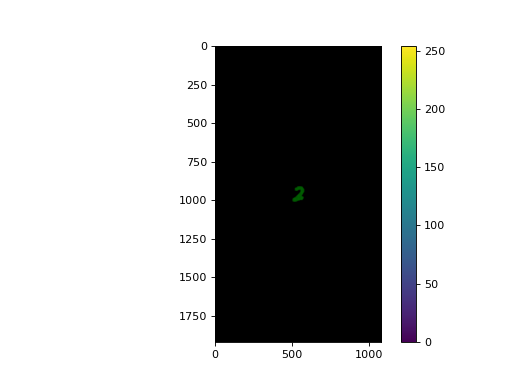

In [24]:
""" Generate the images to be displayed on the phone and save them. """

input_data, data_labels = next(iter(subset_data_loader))
input_data = input_data.view(X.size(0), -1)

px_margin = 1
blankImage = torch.zeros(3, 1920, 1080, dtype=torch.uint8)

for i, batchIdx in enumerate(trainID_range):
    
    # x is the output of the previous layer L-1 (L>0) or the input data (L==0).
    if L > 0:
        x = torch.tensor(df_measured_acts["ORDERED"].loc[batchIdx, L-1, :].values)
        #x = torch.tensor(df_all_acts["a_true"].loc[batchIdx, L-1, :].values) # test mode
    elif L == 0:
        x = input_data[batchIdx,:]
    
    # Normalize each x to its max and min and scale to 7 bit to match the dynamical range of the phone.
    # The operations here are performed EXACTLY the same as in ONN_layer_prop()
    x_til,_,_ = X_transform(x.view(-1,1))
    x_norm = X_digitize(x_til.squeeze()).round().type(torch.long) # round() cannot be omitted for type(torch.long) sometimes work as floor(0)
    
    # Add the singla-pixel frame for image alignment.
    imToPhone = blankImage.clone()
    x_norm_expan = torch.repeat_interleave(x_norm.view(28,-1), expan_r, dim=0)
    x_norm_expan = torch.repeat_interleave(x_norm_expan, expan_r, dim=1)
    x_norm_spar = x_norm_expan
    x_norm_spar[::expan_r,:] = 0
    x_norm_spar[(expan_r-px_margin)::expan_r,:] = 0
    x_norm_spar[:,::expan_r] = 0
    x_norm_spar[:,(expan_r-px_margin)::expan_r] = 0
    x_norm_embedded = CenterEmbedding(x_norm_spar, blankImage[1,:,:].type(torch.long))
    imToPhone[1, :, :] = lut_p[x_norm_embedded.type(torch.long)] # no uniformness correction
    #phone_corr_numpy = lut_p[(x_norm_embedded * sub_phone_mask).type(torch.long)]
    #imToPhone[1, :, :] = phone_corr_numpy

    # Save the generated image
    imToPhone_PIL = transforms.ToPILImage()(imToPhone)
    imToPhone_PIL.save((phoneImagePath / f"test_{expan_r}x_gap2px_MLP_fc{L}_digit_{data_labels[batchIdx]}_{batchIdx:05d}.png").as_posix())

# Generate and save a black image to be displayed on the phone for background and power saving.
blackImage_PIL = transforms.ToPILImage()(blankImage)
blackImage_PIL.save((phoneImagePath / "black.png").as_posix())

print("The normalized weight matrix to be applied on the SLM looks like below:")
fig, ax = plt.subplots()
im = ax.imshow(imToPhone_PIL)
fig.colorbar(im, ax=ax)
plt.show()

In [34]:
ConvertPhoneImageToSLMImage(imToPhone[1,:,:], 1.0).save((slmWeightPath / "alignment_check").as_posix(), format = 'bmp')

# Acquire Data

In [25]:
""" Set up MPPC experiment scheme. """

repeats = 100
oscope.set_range(6)
oscope.set_offset(2)
oscope_info(oscope)

{'ID': 'HEWLETT-PACKARD,54845A,US40240103,A.04.50\n',
 'x_range': 0.0001,
 'x_unit': 'SECOND',
 'y_range': 6.0,
 'y_unit': 'VOLT',
 'y_offset': 2.0,
 'y_bounds': [-1.0, 5.0]}

In [29]:
""" Set up the (empty) dataframe table for taking data. """

import pandas

repeats = 100
test_digit_idx = np.arange(20)
node_idx = [*range(100), "sum", "bkg"]
time_ranges = [0.0001, ]
#rowMultiIdx = pandas.MultiIndex.from_product([test_digit_idx, node_idx, time_ranges, np.arange(repeats)], names=["test_ID", "output_node", "time_range", "repeats"])
rowMultiIdx = pandas.MultiIndex.from_product([node_idx, time_ranges, np.arange(repeats)], names=["output_node", "time_range", "repeats"])
#df_volTraces = pandas.DataFrame(index=rowMultiIdx, columns=np.arange(1004))

phoneLoadPath = phoneImagePath 
slmLoadPath = slmWeightPath 

print(phoneLoadPath)
print(slmLoadPath)
print(rowMultiIdx)
#print(df_volTraces)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\phone_images
D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\slm_weights
MultiIndex([(    0, 0.0001,  0),
            (    0, 0.0001,  1),
            (    0, 0.0001,  2),
            (    0, 0.0001,  3),
            (    0, 0.0001,  4),
            (    0, 0.0001,  5),
            (    0, 0.0001,  6),
            (    0, 0.0001,  7),
            (    0, 0.0001,  8),
            (    0, 0.0001,  9),
            ...
            ('bkg', 0.0001, 90),
            ('bkg', 0.0001, 91),
            ('bkg', 0.0001, 92),
            ('bkg', 0.0001, 93),
            ('bkg', 0.0001, 94),
            ('bkg', 0.0001, 95),
            ('bkg', 0.0001, 96),
            ('bkg', 0.0001, 97),
            ('bkg', 0.0001, 98),
            ('bkg', 0.0001, 99)],
           names=['output_node', 'time_range', 'repeats'], length=10200)


In [30]:
""" Perform the inference of the trained model with ONN on test digits, and save the data. """

import joblib, pickle, time

exp_time = datetime.now()
savePath = resultPath /  (f"MLP_fc{L}_{expan_r}x_marg_1px_MPPC_{exp_time:%m%d_%H%M%S}")
print(savePath)
if not os.path.exists(savePath.as_posix()):
    os.makedirs(savePath.as_posix())

oscope.instrument.write("TIM:RANG 0.0001")

joblib.dump([oscope_info(oscope),], savePath / 'exp_info.pkl')
dataFile = pandas.HDFStore((savePath / "mppc_vol_meas.h5").as_posix())

# write a black image to the phone to take the background
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)

for idx in range(180, 200):
#for idx in range(20):
    t0 = time.time()
    # Record background to capture potential voltage bias drift
    aoab.write(blackImage_byte)
    #time.sleep(0.5)
    slmPattern_PIL = Image.open((slmLoadPath / f"SLM_solid_0.bmp").as_posix())
    slm.updateArray((np.array(slmPattern_PIL)).astype('uint8'))
    time.sleep(0.5)
    
    df = pandas.DataFrame(index=rowMultiIdx, columns=np.arange(1004))

    for i in rowMultiIdx.get_level_values("repeats").unique(): 
        trace = oscope.get_waveform()
        df.loc[("bkg", 0.0001, i), range(len(trace))] = trace
        time.sleep(0.04)
    print(f"time_span=0.0001s, test_ID={idx}, label={data_labels[idx]}, output_node=bkg, voltage={trace.mean()}")
        
    # Load the phone pattern
    phonePattern_PIL = Image.open((phoneLoadPath / f"test_{expan_r}x_gap2px_MLP_fc{L}_digit_{data_labels[idx]}_{idx:05d}.png").as_posix())
    phonePattern_byte = PIL_to_bytestream(phonePattern_PIL)
    aoab.write(phonePattern_byte)
    time.sleep(0.5) # Wait for the pattern applied to be stable
    for n in rowMultiIdx.get_level_values("output_node").unique().drop("bkg"):
        # refresh the slm pattern
        slmPattern_PIL = Image.open((slmLoadPath / f"SLM_MLP_{expan_r}x_fc{L}_w{n}.bmp").as_posix())
        slm.updateArray((np.array(slmPattern_PIL)).astype('uint8'))
        time.sleep(0.5) # Wait for the pattern applied to be stable
        
        for i in rowMultiIdx.get_level_values("repeats").unique(): 
            trace = oscope.get_waveform()
            df.loc[(n, 0.0001, i), range(len(trace))] = trace
            time.sleep(0.04)
        print(f"time_span=0.0001s, test_ID={idx}, label={data_labels[idx]}, output_node={n}, voltage={trace.mean()}")
            
        if n == 10 and idx == 180:
            print("20 s to exit anydesk")
            time.sleep(20)  
            
    t1 = time.time()
    print(f"Time consumed for 1 sample = {t1-t0} s")
    t0 = t1
    dataFile[str(idx)]=df 
    
dataFile.close()
aoab.write(blackImage_byte)
print("Finished! Safe to change code now.")

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\MLP_fc0_5x_marg_1px_MPPC_1220_124131


C:\Users\Logan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


time_span=0.0001s, test_ID=180, label=1, output_node=bkg, voltage=-0.0031165340915322304
time_span=0.0001s, test_ID=180, label=1, output_node=0, voltage=0.004261952359229326
time_span=0.0001s, test_ID=180, label=1, output_node=1, voltage=0.0043017929419875145
time_span=0.0001s, test_ID=180, label=1, output_node=2, voltage=0.0028117529582232237
time_span=0.0001s, test_ID=180, label=1, output_node=3, voltage=0.001362549839541316
time_span=0.0001s, test_ID=180, label=1, output_node=4, voltage=0.007617529947310686
time_span=0.0001s, test_ID=180, label=1, output_node=5, voltage=0.0004910359275527298
time_span=0.0001s, test_ID=180, label=1, output_node=6, voltage=0.00555677292868495
time_span=0.0001s, test_ID=180, label=1, output_node=7, voltage=0.005204183515161276
time_span=0.0001s, test_ID=180, label=1, output_node=8, voltage=0.003472111653536558
time_span=0.0001s, test_ID=180, label=1, output_node=9, voltage=0.001879482064396143
time_span=0.0001s, test_ID=180, label=1, output_node=10, vo

time_span=0.0001s, test_ID=180, label=1, output_node=94, voltage=0.0018017928814515471
time_span=0.0001s, test_ID=180, label=1, output_node=95, voltage=0.005429283250123262
time_span=0.0001s, test_ID=180, label=1, output_node=96, voltage=0.0017410358414053917
time_span=0.0001s, test_ID=180, label=1, output_node=97, voltage=0.0038914342876523733
time_span=0.0001s, test_ID=180, label=1, output_node=98, voltage=0.003668326884508133
time_span=0.0001s, test_ID=180, label=1, output_node=99, voltage=0.00572211155667901
time_span=0.0001s, test_ID=180, label=1, output_node=sum, voltage=0.011390439234673977
Time consumed for 1 sample = 1214.491173505783 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Logan\Anaconda3\lib\site-packages\pandas\io\pytables.py:556: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis1_level0] [items->None]

  self.put(key, value)
C:\Users\Logan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
             994,  995,  996,  997,

time_span=0.0001s, test_ID=181, label=8, output_node=bkg, voltage=-0.004434262402355671
time_span=0.0001s, test_ID=181, label=8, output_node=0, voltage=0.02280876412987709
time_span=0.0001s, test_ID=181, label=8, output_node=1, voltage=0.01699701137840748
time_span=0.0001s, test_ID=181, label=8, output_node=2, voltage=0.02129681222140789
time_span=0.0001s, test_ID=181, label=8, output_node=3, voltage=0.015394422225654125
time_span=0.0001s, test_ID=181, label=8, output_node=4, voltage=0.01727191172540188
time_span=0.0001s, test_ID=181, label=8, output_node=5, voltage=0.01662250980734825
time_span=0.0001s, test_ID=181, label=8, output_node=6, voltage=0.018840637058019638
time_span=0.0001s, test_ID=181, label=8, output_node=7, voltage=0.02551095560193062
time_span=0.0001s, test_ID=181, label=8, output_node=8, voltage=0.020379481837153435
time_span=0.0001s, test_ID=181, label=8, output_node=9, voltage=0.01432669349014759
time_span=0.0001s, test_ID=181, label=8, output_node=10, voltage=0.01

time_span=0.0001s, test_ID=181, label=8, output_node=95, voltage=0.01662250980734825
time_span=0.0001s, test_ID=181, label=8, output_node=96, voltage=0.018154384568333626
time_span=0.0001s, test_ID=181, label=8, output_node=97, voltage=0.015972111374139786
time_span=0.0001s, test_ID=181, label=8, output_node=98, voltage=0.015167329460382462
time_span=0.0001s, test_ID=181, label=8, output_node=99, voltage=0.016659362241625786
time_span=0.0001s, test_ID=181, label=8, output_node=sum, voltage=0.04042031988501549
Time consumed for 1 sample = 1206.739015340805 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=182, label=5, output_node=bkg, voltage=-0.006096614059060812
time_span=0.0001s, test_ID=182, label=5, output_node=0, voltage=0.004719123709946871
time_span=0.0001s, test_ID=182, label=5, output_node=1, voltage=0.008810756728053093
time_span=0.0001s, test_ID=182, label=5, output_node=2, voltage=0.01017529796808958
time_span=0.0001s, test_ID=182, label=5, output_node=3, voltage=0.007649402599781752
time_span=0.0001s, test_ID=182, label=5, output_node=4, voltage=0.0047749001532793045
time_span=0.0001s, test_ID=182, label=5, output_node=5, voltage=0.008591634221374989
time_span=0.0001s, test_ID=182, label=5, output_node=6, voltage=0.010847608558833599
time_span=0.0001s, test_ID=182, label=5, output_node=7, voltage=0.008099601604044437
time_span=0.0001s, test_ID=182, label=5, output_node=8, voltage=0.0030926296021789312
time_span=0.0001s, test_ID=182, label=5, output_node=9, voltage=0.0031782870646566153
time_span=0.0001s, test_ID=182, label=5, output_node=10, vol

time_span=0.0001s, test_ID=182, label=5, output_node=95, voltage=0.010754979215562344
time_span=0.0001s, test_ID=182, label=5, output_node=96, voltage=0.003523904597386718
time_span=0.0001s, test_ID=182, label=5, output_node=97, voltage=0.0049422308802604675
time_span=0.0001s, test_ID=182, label=5, output_node=98, voltage=0.008129483088850975
time_span=0.0001s, test_ID=182, label=5, output_node=99, voltage=0.007384462282061577
time_span=0.0001s, test_ID=182, label=5, output_node=sum, voltage=0.017305776476860046
Time consumed for 1 sample = 1199.6570105552673 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '182'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=183, label=0, output_node=bkg, voltage=-0.006234063766896725
time_span=0.0001s, test_ID=183, label=0, output_node=0, voltage=0.019208166748285294
time_span=0.0001s, test_ID=183, label=0, output_node=1, voltage=0.015600597485899925
time_span=0.0001s, test_ID=183, label=0, output_node=2, voltage=0.02129681222140789
time_span=0.0001s, test_ID=183, label=0, output_node=3, voltage=0.023427290841937065
time_span=0.0001s, test_ID=183, label=0, output_node=4, voltage=0.01571115478873253
time_span=0.0001s, test_ID=183, label=0, output_node=5, voltage=0.01117729116231203
time_span=0.0001s, test_ID=183, label=0, output_node=6, voltage=0.024496015161275864
time_span=0.0001s, test_ID=183, label=0, output_node=7, voltage=0.024035856127738953
time_span=0.0001s, test_ID=183, label=0, output_node=8, voltage=0.027079680934548378
time_span=0.0001s, test_ID=183, label=0, output_node=9, voltage=0.021243026480078697
time_span=0.0001s, test_ID=183, label=0, output_node=10, voltage=

time_span=0.0001s, test_ID=183, label=0, output_node=95, voltage=0.01942828670144081
time_span=0.0001s, test_ID=183, label=0, output_node=96, voltage=0.010446215979754925
time_span=0.0001s, test_ID=183, label=0, output_node=97, voltage=0.022455180063843727
time_span=0.0001s, test_ID=183, label=0, output_node=98, voltage=0.021250996738672256
time_span=0.0001s, test_ID=183, label=0, output_node=99, voltage=0.020621513947844505
time_span=0.0001s, test_ID=183, label=0, output_node=sum, voltage=0.05015139654278755
Time consumed for 1 sample = 1209.9009895324707 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '183'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=184, label=8, output_node=bkg, voltage=-0.0044272905215620995
time_span=0.0001s, test_ID=184, label=8, output_node=0, voltage=0.015430279076099396
time_span=0.0001s, test_ID=184, label=8, output_node=1, voltage=0.012886454351246357
time_span=0.0001s, test_ID=184, label=8, output_node=2, voltage=0.013463147915899754
time_span=0.0001s, test_ID=184, label=8, output_node=3, voltage=0.013808764517307281
time_span=0.0001s, test_ID=184, label=8, output_node=4, voltage=0.011517927050590515
time_span=0.0001s, test_ID=184, label=8, output_node=5, voltage=0.010062748566269875
time_span=0.0001s, test_ID=184, label=8, output_node=6, voltage=0.011142430827021599
time_span=0.0001s, test_ID=184, label=8, output_node=7, voltage=0.014215139672160149
time_span=0.0001s, test_ID=184, label=8, output_node=8, voltage=0.014703188091516495
time_span=0.0001s, test_ID=184, label=8, output_node=9, voltage=0.01184462197124958
time_span=0.0001s, test_ID=184, label=8, output_node=10, volta

time_span=0.0001s, test_ID=184, label=8, output_node=95, voltage=0.009283864870667458
time_span=0.0001s, test_ID=184, label=8, output_node=96, voltage=0.012028884142637253
time_span=0.0001s, test_ID=184, label=8, output_node=97, voltage=0.012248007580637932
time_span=0.0001s, test_ID=184, label=8, output_node=98, voltage=0.01064043864607811
time_span=0.0001s, test_ID=184, label=8, output_node=99, voltage=0.011425299569964409
time_span=0.0001s, test_ID=184, label=8, output_node=sum, voltage=0.03029482066631317
Time consumed for 1 sample = 1202.8652820587158 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '184'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=185, label=9, output_node=bkg, voltage=-0.004004979971796274
time_span=0.0001s, test_ID=185, label=9, output_node=0, voltage=0.008655378594994545
time_span=0.0001s, test_ID=185, label=9, output_node=1, voltage=0.010108565911650658
time_span=0.0001s, test_ID=185, label=9, output_node=2, voltage=0.013581673614680767
time_span=0.0001s, test_ID=185, label=9, output_node=3, voltage=0.009534860961139202
time_span=0.0001s, test_ID=185, label=9, output_node=4, voltage=0.012226096354424953
time_span=0.0001s, test_ID=185, label=9, output_node=5, voltage=0.01704282872378826
time_span=0.0001s, test_ID=185, label=9, output_node=6, voltage=0.00843725074082613
time_span=0.0001s, test_ID=185, label=9, output_node=7, voltage=0.012183267623186111
time_span=0.0001s, test_ID=185, label=9, output_node=8, voltage=0.009744022972881794
time_span=0.0001s, test_ID=185, label=9, output_node=9, voltage=0.01485258899629116
time_span=0.0001s, test_ID=185, label=9, output_node=10, voltage=

time_span=0.0001s, test_ID=185, label=9, output_node=95, voltage=0.010641434229910374
time_span=0.0001s, test_ID=185, label=9, output_node=96, voltage=0.010489043779671192
time_span=0.0001s, test_ID=185, label=9, output_node=97, voltage=0.008213147521018982
time_span=0.0001s, test_ID=185, label=9, output_node=98, voltage=0.00959760881960392
time_span=0.0001s, test_ID=185, label=9, output_node=99, voltage=0.010546812787652016
time_span=0.0001s, test_ID=185, label=9, output_node=sum, voltage=0.028708167374134064
Time consumed for 1 sample = 1201.9383883476257 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '185'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=186, label=2, output_node=bkg, voltage=-0.0028545819222927094
time_span=0.0001s, test_ID=186, label=2, output_node=0, voltage=0.022045815363526344
time_span=0.0001s, test_ID=186, label=2, output_node=1, voltage=0.02353685349225998
time_span=0.0001s, test_ID=186, label=2, output_node=2, voltage=0.01885657198727131
time_span=0.0001s, test_ID=186, label=2, output_node=3, voltage=0.0298934243619442
time_span=0.0001s, test_ID=186, label=2, output_node=4, voltage=0.020492032170295715
time_span=0.0001s, test_ID=186, label=2, output_node=5, voltage=0.015017928555607796
time_span=0.0001s, test_ID=186, label=2, output_node=6, voltage=0.018998008221387863
time_span=0.0001s, test_ID=186, label=2, output_node=7, voltage=0.030734064057469368
time_span=0.0001s, test_ID=186, label=2, output_node=8, voltage=0.022019920870661736
time_span=0.0001s, test_ID=186, label=2, output_node=9, voltage=0.015673307701945305
time_span=0.0001s, test_ID=186, label=2, output_node=10, voltage=

time_span=0.0001s, test_ID=186, label=2, output_node=95, voltage=0.025189243257045746
time_span=0.0001s, test_ID=186, label=2, output_node=96, voltage=0.01811055839061737
time_span=0.0001s, test_ID=186, label=2, output_node=97, voltage=0.029257968068122864
time_span=0.0001s, test_ID=186, label=2, output_node=98, voltage=0.02577490173280239
time_span=0.0001s, test_ID=186, label=2, output_node=99, voltage=0.021382469683885574
time_span=0.0001s, test_ID=186, label=2, output_node=sum, voltage=0.05041234940290451
Time consumed for 1 sample = 1211.6711883544922 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '186'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=187, label=5, output_node=bkg, voltage=-0.005420319270342588
time_span=0.0001s, test_ID=187, label=5, output_node=0, voltage=0.010087649337947369
time_span=0.0001s, test_ID=187, label=5, output_node=1, voltage=0.01634860783815384
time_span=0.0001s, test_ID=187, label=5, output_node=2, voltage=0.011462152004241943
time_span=0.0001s, test_ID=187, label=5, output_node=3, voltage=0.0188615545630455
time_span=0.0001s, test_ID=187, label=5, output_node=4, voltage=0.012315737083554268
time_span=0.0001s, test_ID=187, label=5, output_node=5, voltage=0.01041334681212902
time_span=0.0001s, test_ID=187, label=5, output_node=6, voltage=0.010980079881846905
time_span=0.0001s, test_ID=187, label=5, output_node=7, voltage=0.014554781839251518
time_span=0.0001s, test_ID=187, label=5, output_node=8, voltage=0.013648406602442265
time_span=0.0001s, test_ID=187, label=5, output_node=9, voltage=0.011634461581707
time_span=0.0001s, test_ID=187, label=5, output_node=10, voltage=0.01

time_span=0.0001s, test_ID=187, label=5, output_node=95, voltage=0.017566734924912453
time_span=0.0001s, test_ID=187, label=5, output_node=96, voltage=0.010126493871212006
time_span=0.0001s, test_ID=187, label=5, output_node=97, voltage=0.015116533264517784
time_span=0.0001s, test_ID=187, label=5, output_node=98, voltage=0.012748007662594318
time_span=0.0001s, test_ID=187, label=5, output_node=99, voltage=0.013343625701963902
time_span=0.0001s, test_ID=187, label=5, output_node=sum, voltage=0.032385457307100296
Time consumed for 1 sample = 1205.7202291488647 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '187'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=188, label=0, output_node=bkg, voltage=-0.005127490032464266
time_span=0.0001s, test_ID=188, label=0, output_node=0, voltage=0.017109563574194908
time_span=0.0001s, test_ID=188, label=0, output_node=1, voltage=0.023749005049467087
time_span=0.0001s, test_ID=188, label=0, output_node=2, voltage=0.02044721320271492
time_span=0.0001s, test_ID=188, label=0, output_node=3, voltage=0.021857568994164467
time_span=0.0001s, test_ID=188, label=0, output_node=4, voltage=0.013896414078772068
time_span=0.0001s, test_ID=188, label=0, output_node=5, voltage=0.012184263207018375
time_span=0.0001s, test_ID=188, label=0, output_node=6, voltage=0.02075498178601265
time_span=0.0001s, test_ID=188, label=0, output_node=7, voltage=0.018996015191078186
time_span=0.0001s, test_ID=188, label=0, output_node=8, voltage=0.016431273892521858
time_span=0.0001s, test_ID=188, label=0, output_node=9, voltage=0.02115139365196228
time_span=0.0001s, test_ID=188, label=0, output_node=10, voltage=

time_span=0.0001s, test_ID=188, label=0, output_node=95, voltage=0.022399403154850006
time_span=0.0001s, test_ID=188, label=0, output_node=96, voltage=0.01731972023844719
time_span=0.0001s, test_ID=188, label=0, output_node=97, voltage=0.01797410473227501
time_span=0.0001s, test_ID=188, label=0, output_node=98, voltage=0.023442231118679047
time_span=0.0001s, test_ID=188, label=0, output_node=99, voltage=0.021924303844571114
time_span=0.0001s, test_ID=188, label=0, output_node=sum, voltage=0.04915139451622963
Time consumed for 1 sample = 1211.2925741672516 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '188'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=189, label=1, output_node=bkg, voltage=-0.005798804108053446
time_span=0.0001s, test_ID=189, label=1, output_node=0, voltage=0.0010687251342460513
time_span=0.0001s, test_ID=189, label=1, output_node=1, voltage=0.0017559761181473732
time_span=0.0001s, test_ID=189, label=1, output_node=2, voltage=0.0025627489667385817
time_span=0.0001s, test_ID=189, label=1, output_node=3, voltage=-0.0009392430074512959
time_span=0.0001s, test_ID=189, label=1, output_node=4, voltage=0.0017888445872813463
time_span=0.0001s, test_ID=189, label=1, output_node=5, voltage=0.0024671312421560287
time_span=0.0001s, test_ID=189, label=1, output_node=6, voltage=0.006294820457696915
time_span=0.0001s, test_ID=189, label=1, output_node=7, voltage=0.0013545817928388715
time_span=0.0001s, test_ID=189, label=1, output_node=8, voltage=-0.002042828593403101
time_span=0.0001s, test_ID=189, label=1, output_node=9, voltage=-0.00046513957204297185
time_span=0.0001s, test_ID=189, label=1, output_no

time_span=0.0001s, test_ID=189, label=1, output_node=93, voltage=-0.0006115537253208458
time_span=0.0001s, test_ID=189, label=1, output_node=94, voltage=-0.0006484063342213631
time_span=0.0001s, test_ID=189, label=1, output_node=95, voltage=0.0030278884805738926
time_span=0.0001s, test_ID=189, label=1, output_node=96, voltage=-0.0009960158495232463
time_span=0.0001s, test_ID=189, label=1, output_node=97, voltage=-0.0032241034787148237
time_span=0.0001s, test_ID=189, label=1, output_node=98, voltage=-0.0009731075842864811
time_span=0.0001s, test_ID=189, label=1, output_node=99, voltage=0.002607569796964526
time_span=0.0001s, test_ID=189, label=1, output_node=sum, voltage=0.0067390440963208675
Time consumed for 1 sample = 1200.8918297290802 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '189'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=190, label=1, output_node=bkg, voltage=-0.006010956130921841
time_span=0.0001s, test_ID=190, label=1, output_node=0, voltage=0.003598605515435338
time_span=0.0001s, test_ID=190, label=1, output_node=1, voltage=0.010577688924968243
time_span=0.0001s, test_ID=190, label=1, output_node=2, voltage=0.006264940369874239
time_span=0.0001s, test_ID=190, label=1, output_node=3, voltage=0.0067440238781273365
time_span=0.0001s, test_ID=190, label=1, output_node=4, voltage=0.013136453926563263
time_span=0.0001s, test_ID=190, label=1, output_node=5, voltage=0.011993028223514557
time_span=0.0001s, test_ID=190, label=1, output_node=6, voltage=0.01080179214477539
time_span=0.0001s, test_ID=190, label=1, output_node=7, voltage=0.011488047428429127
time_span=0.0001s, test_ID=190, label=1, output_node=8, voltage=0.008171315304934978
time_span=0.0001s, test_ID=190, label=1, output_node=9, voltage=0.004888446070253849
time_span=0.0001s, test_ID=190, label=1, output_node=10, volta

time_span=0.0001s, test_ID=190, label=1, output_node=95, voltage=0.009803785011172295
time_span=0.0001s, test_ID=190, label=1, output_node=96, voltage=0.00686254957690835
time_span=0.0001s, test_ID=190, label=1, output_node=97, voltage=0.01168824639171362
time_span=0.0001s, test_ID=190, label=1, output_node=98, voltage=0.012694223783910275
time_span=0.0001s, test_ID=190, label=1, output_node=99, voltage=0.008721115998923779
time_span=0.0001s, test_ID=190, label=1, output_node=sum, voltage=0.025794818997383118
Time consumed for 1 sample = 1202.1020131111145 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '190'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=191, label=1, output_node=bkg, voltage=-0.005875498056411743
time_span=0.0001s, test_ID=191, label=1, output_node=0, voltage=0.0023725100327283144
time_span=0.0001s, test_ID=191, label=1, output_node=1, voltage=0.0029492031317204237
time_span=0.0001s, test_ID=191, label=1, output_node=2, voltage=0.005375498440116644
time_span=0.0001s, test_ID=191, label=1, output_node=3, voltage=0.004117530304938555
time_span=0.0001s, test_ID=191, label=1, output_node=4, voltage=0.002759960014373064
time_span=0.0001s, test_ID=191, label=1, output_node=5, voltage=0.002109561813995242
time_span=0.0001s, test_ID=191, label=1, output_node=6, voltage=0.006731076166033745
time_span=0.0001s, test_ID=191, label=1, output_node=7, voltage=0.003934262786060572
time_span=0.0001s, test_ID=191, label=1, output_node=8, voltage=0.0028565735556185246
time_span=0.0001s, test_ID=191, label=1, output_node=9, voltage=0.0011065737344324589
time_span=0.0001s, test_ID=191, label=1, output_node=10, v

time_span=0.0001s, test_ID=191, label=1, output_node=94, voltage=0.004674302414059639
time_span=0.0001s, test_ID=191, label=1, output_node=95, voltage=0.0050926292315125465
time_span=0.0001s, test_ID=191, label=1, output_node=96, voltage=0.003465139539912343
time_span=0.0001s, test_ID=191, label=1, output_node=97, voltage=0.0023466134443879128
time_span=0.0001s, test_ID=191, label=1, output_node=98, voltage=-0.00014741036284249276
time_span=0.0001s, test_ID=191, label=1, output_node=99, voltage=0.002664342289790511
time_span=0.0001s, test_ID=191, label=1, output_node=sum, voltage=0.015355577692389488
Time consumed for 1 sample = 1199.192355632782 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=192, label=0, output_node=bkg, voltage=-0.004725099075585604
time_span=0.0001s, test_ID=192, label=0, output_node=0, voltage=0.016984064131975174
time_span=0.0001s, test_ID=192, label=0, output_node=1, voltage=0.012999999336898327
time_span=0.0001s, test_ID=192, label=0, output_node=2, voltage=0.014326694421470165
time_span=0.0001s, test_ID=192, label=0, output_node=3, voltage=0.021298803389072418
time_span=0.0001s, test_ID=192, label=0, output_node=4, voltage=0.011216134764254093
time_span=0.0001s, test_ID=192, label=0, output_node=5, voltage=0.006857569795101881
time_span=0.0001s, test_ID=192, label=0, output_node=6, voltage=0.020685259252786636
time_span=0.0001s, test_ID=192, label=0, output_node=7, voltage=0.011006972752511501
time_span=0.0001s, test_ID=192, label=0, output_node=8, voltage=0.012148406356573105
time_span=0.0001s, test_ID=192, label=0, output_node=9, voltage=0.01881474070250988
time_span=0.0001s, test_ID=192, label=0, output_node=10, voltag

time_span=0.0001s, test_ID=192, label=0, output_node=95, voltage=0.0126942228525877
time_span=0.0001s, test_ID=192, label=0, output_node=96, voltage=0.01418924331665039
time_span=0.0001s, test_ID=192, label=0, output_node=97, voltage=0.017688246443867683
time_span=0.0001s, test_ID=192, label=0, output_node=98, voltage=0.016301793977618217
time_span=0.0001s, test_ID=192, label=0, output_node=99, voltage=0.015361553058028221
time_span=0.0001s, test_ID=192, label=0, output_node=sum, voltage=0.039289843291044235
Time consumed for 1 sample = 1204.6972386837006 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=193, label=9, output_node=bkg, voltage=-0.00447111576795578
time_span=0.0001s, test_ID=193, label=9, output_node=0, voltage=0.004729083739221096
time_span=0.0001s, test_ID=193, label=9, output_node=1, voltage=0.007038845214992762
time_span=0.0001s, test_ID=193, label=9, output_node=2, voltage=0.015438247472047806
time_span=0.0001s, test_ID=193, label=9, output_node=3, voltage=0.007581673096865416
time_span=0.0001s, test_ID=193, label=9, output_node=4, voltage=0.008570716716349125
time_span=0.0001s, test_ID=193, label=9, output_node=5, voltage=0.009169322438538074
time_span=0.0001s, test_ID=193, label=9, output_node=6, voltage=0.005423306953161955
time_span=0.0001s, test_ID=193, label=9, output_node=7, voltage=0.01103187259286642
time_span=0.0001s, test_ID=193, label=9, output_node=8, voltage=0.007845617830753326
time_span=0.0001s, test_ID=193, label=9, output_node=9, voltage=0.008858566172420979
time_span=0.0001s, test_ID=193, label=9, output_node=10, voltage

time_span=0.0001s, test_ID=193, label=9, output_node=95, voltage=0.010965140536427498
time_span=0.0001s, test_ID=193, label=9, output_node=96, voltage=0.010096613317728043
time_span=0.0001s, test_ID=193, label=9, output_node=97, voltage=0.009753984399139881
time_span=0.0001s, test_ID=193, label=9, output_node=98, voltage=0.008363545872271061
time_span=0.0001s, test_ID=193, label=9, output_node=99, voltage=0.009981075301766396
time_span=0.0001s, test_ID=193, label=9, output_node=sum, voltage=0.025233067572116852
Time consumed for 1 sample = 1198.9469175338745 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=194, label=0, output_node=bkg, voltage=-0.00536454189568758
time_span=0.0001s, test_ID=194, label=0, output_node=0, voltage=0.013569721020758152
time_span=0.0001s, test_ID=194, label=0, output_node=1, voltage=0.015858566388487816
time_span=0.0001s, test_ID=194, label=0, output_node=2, voltage=0.01233764924108982
time_span=0.0001s, test_ID=194, label=0, output_node=3, voltage=0.01753685250878334
time_span=0.0001s, test_ID=194, label=0, output_node=4, voltage=0.012534860521554947
time_span=0.0001s, test_ID=194, label=0, output_node=5, voltage=0.009327689185738564
time_span=0.0001s, test_ID=194, label=0, output_node=6, voltage=0.01982569508254528
time_span=0.0001s, test_ID=194, label=0, output_node=7, voltage=0.015728088095784187
time_span=0.0001s, test_ID=194, label=0, output_node=8, voltage=0.01870816759765148
time_span=0.0001s, test_ID=194, label=0, output_node=9, voltage=0.014898406341671944
time_span=0.0001s, test_ID=194, label=0, output_node=10, voltage=0.

time_span=0.0001s, test_ID=194, label=0, output_node=95, voltage=0.013691235333681107
time_span=0.0001s, test_ID=194, label=0, output_node=96, voltage=0.01537051796913147
time_span=0.0001s, test_ID=194, label=0, output_node=97, voltage=0.020588647574186325
time_span=0.0001s, test_ID=194, label=0, output_node=98, voltage=0.017340637743473053
time_span=0.0001s, test_ID=194, label=0, output_node=99, voltage=0.017896417528390884
time_span=0.0001s, test_ID=194, label=0, output_node=sum, voltage=0.03775298595428467
Time consumed for 1 sample = 1206.5608777999878 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '194'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=195, label=3, output_node=bkg, voltage=-0.003943226765841246
time_span=0.0001s, test_ID=195, label=3, output_node=0, voltage=-0.00028685267898254097
time_span=0.0001s, test_ID=195, label=3, output_node=1, voltage=0.001936255139298737
time_span=0.0001s, test_ID=195, label=3, output_node=2, voltage=0.003467131406068802
time_span=0.0001s, test_ID=195, label=3, output_node=3, voltage=0.002545817056670785
time_span=0.0001s, test_ID=195, label=3, output_node=4, voltage=0.0016842628829181194
time_span=0.0001s, test_ID=195, label=3, output_node=5, voltage=0.005261952057480812
time_span=0.0001s, test_ID=195, label=3, output_node=6, voltage=0.0038555776700377464
time_span=0.0001s, test_ID=195, label=3, output_node=7, voltage=0.005535856354981661
time_span=0.0001s, test_ID=195, label=3, output_node=8, voltage=0.0010039840126410127
time_span=0.0001s, test_ID=195, label=3, output_node=9, voltage=0.0011802789522334933
time_span=0.0001s, test_ID=195, label=3, output_node=10

time_span=0.0001s, test_ID=195, label=3, output_node=94, voltage=0.0005278884200379252
time_span=0.0001s, test_ID=195, label=3, output_node=95, voltage=0.0017231078818440437
time_span=0.0001s, test_ID=195, label=3, output_node=96, voltage=0.0021623503416776657
time_span=0.0001s, test_ID=195, label=3, output_node=97, voltage=0.00140836660284549
time_span=0.0001s, test_ID=195, label=3, output_node=98, voltage=0.000788844539783895
time_span=0.0001s, test_ID=195, label=3, output_node=99, voltage=0.003376494161784649
time_span=0.0001s, test_ID=195, label=3, output_node=sum, voltage=0.008248007856309414
Time consumed for 1 sample = 1199.6495254039764 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=196, label=1, output_node=bkg, voltage=-0.005982071626931429
time_span=0.0001s, test_ID=196, label=1, output_node=0, voltage=0.009152390994131565
time_span=0.0001s, test_ID=196, label=1, output_node=1, voltage=0.008064741268754005
time_span=0.0001s, test_ID=196, label=1, output_node=2, voltage=0.004199202638119459
time_span=0.0001s, test_ID=196, label=1, output_node=3, voltage=0.007500000298023224
time_span=0.0001s, test_ID=196, label=1, output_node=4, voltage=0.007455179467797279
time_span=0.0001s, test_ID=196, label=1, output_node=5, voltage=0.0047400398179888725
time_span=0.0001s, test_ID=196, label=1, output_node=6, voltage=0.009000997059047222
time_span=0.0001s, test_ID=196, label=1, output_node=7, voltage=0.006594621576368809
time_span=0.0001s, test_ID=196, label=1, output_node=8, voltage=0.005432270932942629
time_span=0.0001s, test_ID=196, label=1, output_node=9, voltage=0.003518924117088318
time_span=0.0001s, test_ID=196, label=1, output_node=10, volt

time_span=0.0001s, test_ID=196, label=1, output_node=95, voltage=0.005151394288986921
time_span=0.0001s, test_ID=196, label=1, output_node=96, voltage=0.008427291177213192
time_span=0.0001s, test_ID=196, label=1, output_node=97, voltage=0.007807768881320953
time_span=0.0001s, test_ID=196, label=1, output_node=98, voltage=0.007512948475778103
time_span=0.0001s, test_ID=196, label=1, output_node=99, voltage=0.0113884462043643
time_span=0.0001s, test_ID=196, label=1, output_node=sum, voltage=0.025349602103233337
Time consumed for 1 sample = 1200.686919927597 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '196'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=197, label=6, output_node=bkg, voltage=-0.0035846612881869078
time_span=0.0001s, test_ID=197, label=6, output_node=0, voltage=0.014555777423083782
time_span=0.0001s, test_ID=197, label=6, output_node=1, voltage=0.01041334681212902
time_span=0.0001s, test_ID=197, label=6, output_node=2, voltage=0.01511454302817583
time_span=0.0001s, test_ID=197, label=6, output_node=3, voltage=0.017137449234724045
time_span=0.0001s, test_ID=197, label=6, output_node=4, voltage=0.013445219956338406
time_span=0.0001s, test_ID=197, label=6, output_node=5, voltage=0.011332669295370579
time_span=0.0001s, test_ID=197, label=6, output_node=6, voltage=0.014972111210227013
time_span=0.0001s, test_ID=197, label=6, output_node=7, voltage=0.015958167612552643
time_span=0.0001s, test_ID=197, label=6, output_node=8, voltage=0.010987051762640476
time_span=0.0001s, test_ID=197, label=6, output_node=9, voltage=0.01233067736029625
time_span=0.0001s, test_ID=197, label=6, output_node=10, voltage

time_span=0.0001s, test_ID=197, label=6, output_node=95, voltage=0.0066832671873271465
time_span=0.0001s, test_ID=197, label=6, output_node=96, voltage=0.014967132359743118
time_span=0.0001s, test_ID=197, label=6, output_node=97, voltage=0.016403386369347572
time_span=0.0001s, test_ID=197, label=6, output_node=98, voltage=0.009404381737112999
time_span=0.0001s, test_ID=197, label=6, output_node=99, voltage=0.0184183269739151
time_span=0.0001s, test_ID=197, label=6, output_node=sum, voltage=0.03546912223100662
Time consumed for 1 sample = 1206.74578166008 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '197'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=198, label=4, output_node=bkg, voltage=-0.00496613560244441
time_span=0.0001s, test_ID=198, label=4, output_node=0, voltage=0.0039402395486831665
time_span=0.0001s, test_ID=198, label=4, output_node=1, voltage=0.003453186945989728
time_span=0.0001s, test_ID=198, label=4, output_node=2, voltage=0.010364541783928871
time_span=0.0001s, test_ID=198, label=4, output_node=3, voltage=0.006316733080893755
time_span=0.0001s, test_ID=198, label=4, output_node=4, voltage=0.008948205970227718
time_span=0.0001s, test_ID=198, label=4, output_node=5, voltage=0.008669323287904263
time_span=0.0001s, test_ID=198, label=4, output_node=6, voltage=0.007950199767947197
time_span=0.0001s, test_ID=198, label=4, output_node=7, voltage=0.007740039844065905
time_span=0.0001s, test_ID=198, label=4, output_node=8, voltage=0.007813745178282261
time_span=0.0001s, test_ID=198, label=4, output_node=9, voltage=0.012165338732302189
time_span=0.0001s, test_ID=198, label=4, output_node=10, volta

time_span=0.0001s, test_ID=198, label=4, output_node=95, voltage=0.0067091635428369045
time_span=0.0001s, test_ID=198, label=4, output_node=96, voltage=0.008128485642373562
time_span=0.0001s, test_ID=198, label=4, output_node=97, voltage=0.007172311190515757
time_span=0.0001s, test_ID=198, label=4, output_node=98, voltage=0.006903386674821377
time_span=0.0001s, test_ID=198, label=4, output_node=99, voltage=0.005198207218199968
time_span=0.0001s, test_ID=198, label=4, output_node=sum, voltage=0.021648406982421875
Time consumed for 1 sample = 1200.9711618423462 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '198'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=199, label=2, output_node=bkg, voltage=-0.004428287036716938
time_span=0.0001s, test_ID=199, label=2, output_node=0, voltage=0.019910359755158424
time_span=0.0001s, test_ID=199, label=2, output_node=1, voltage=0.02160458080470562
time_span=0.0001s, test_ID=199, label=2, output_node=2, voltage=0.021180277690291405
time_span=0.0001s, test_ID=199, label=2, output_node=3, voltage=0.024395419284701347
time_span=0.0001s, test_ID=199, label=2, output_node=4, voltage=0.015608565881848335
time_span=0.0001s, test_ID=199, label=2, output_node=5, voltage=0.014289841055870056
time_span=0.0001s, test_ID=199, label=2, output_node=6, voltage=0.023365536704659462
time_span=0.0001s, test_ID=199, label=2, output_node=7, voltage=0.030211156234145164
time_span=0.0001s, test_ID=199, label=2, output_node=8, voltage=0.028195219114422798
time_span=0.0001s, test_ID=199, label=2, output_node=9, voltage=0.024605577811598778
time_span=0.0001s, test_ID=199, label=2, output_node=10, voltag

time_span=0.0001s, test_ID=199, label=2, output_node=95, voltage=0.016690239310264587
time_span=0.0001s, test_ID=199, label=2, output_node=96, voltage=0.018835656344890594
time_span=0.0001s, test_ID=199, label=2, output_node=97, voltage=0.027140438556671143
time_span=0.0001s, test_ID=199, label=2, output_node=98, voltage=0.019497012719511986
time_span=0.0001s, test_ID=199, label=2, output_node=99, voltage=0.02075498178601265
time_span=0.0001s, test_ID=199, label=2, output_node=sum, voltage=0.04974103718996048
Time consumed for 1 sample = 1211.3642213344574 s


C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Finished! Safe to change code now.


In [42]:
df_temp = pandas.read_hdf((savePath / "mppc_vol_meas.h5").as_posix(), key='26')
df_temp

0      1      2      3      4      5     \
output_node time_range repeats                                             
0           0.0001     0        0.024  0.027  0.018  0.002 -0.005 -0.008   
                       1        0.033  0.028  0.025  0.015  0.005  0.002   
                       2        0.011  0.008  0.006  0.007  0.004 -0.003   
                       3        0.016  0.003  0.001  0.003      0      0   
                       4        0.002 -0.002 -0.003 -0.006 -0.006      0   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95       0.008  0.009  0.015  0.017  0.008      0   
                       96       0.002 -0.002 -0.002 -0.002 -0.005 -0.008   
                       97      -0.006 -0.003 -0.004 -0.004 -0.005 -0.014   
                       98      -0.021 -0.019 -0.011 -0.005 -0.006 -0.006   
                       99      -0.007 -0.007 -0.008 -0.014 -0.018 -0.019   

                                 6      7      8      9     ...   994    995   \
output_node time_range repeats                              ...                 
0           0.0001     0            0  0.016  0.026  0.032  ...   0.01  0.008   
                       1        0.004  0.007  0.008   0.01  ...   0.02  0.029   
                       2        0.002  0.011  0.005  0.001  ...  0.017  0.018   
                       3            0 -0.002 -0.003 -0.007  ...  0.013  0.014   
                       4        0.004  0.011   0.02  0.013  ...  0.036  0.021   
...                               ...    ...    ...    ...  ...    ...    ...   
bkg         0.0001     95       0.006  0.012  0.011  0.007  ... -0.004 -0.005   
                       96      -0.006 -0.002 -0.003 -0.001  ... -0.003 -0.006   
                       97      -0.022 -0.022 -0.018 -0.006  ... -0.003 -0.021   
                       98      -0.007 -0.003 -0.003 -0.002  ... -0.007 -0.003   
                       99      -0.022 -0.014 -0.008  -0.01  ... -0.007 -0.009   

                                 996    997    998    999    1000   1001  \
output_node time_range repeats                                             
0           0.0001     0        0.006 -0.005 -0.012 -0.009 -0.004 -0.005   
                       1        0.043  0.033  0.035  0.033  0.013  0.009   
                       2         0.01   0.01  0.014  0.033  0.014  0.021   
                       3        0.025  0.032  0.037  0.043  0.033  0.026   
                       4        0.008  0.001   0.01  0.029  0.036   0.04   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95      -0.002 -0.002 -0.006 -0.014 -0.019 -0.022   
                       96      -0.011 -0.021 -0.026 -0.021 -0.019 -0.012   
                       97      -0.034 -0.022 -0.005  0.014  0.013  0.002   
                       98       0.004  0.006  0.004  0.009   0.01  0.008   
                       99      -0.015 -0.011 -0.006  -0.01 -0.009 -0.004   

                                 1002   1003  
output_node time_range repeats                
0           0.0001     0       -0.005  0.003  
                       1        0.018  0.027  
                       2        0.021  0.025  
                       3        0.021  0.016  
                       4        0.033  0.016  
...                               ...    ...  
bkg         0.0001     95      -0.024 -0.019  
                       96      -0.007 -0.007  
                       97      -0.015  -0.02  
                       98       0.013  0.005  
                       99      -0.003 -0.004  

[10200 rows x 1004 columns]

In [31]:
df

0      1      2      3      4      5     \
output_node time_range repeats                                             
0           0.0001     0        0.028  0.033  0.035  0.022  0.003 -0.002   
                       1        0.025  0.001 -0.015 -0.005  0.008  0.012   
                       2       -0.005 -0.004  0.002  0.016  0.024  0.035   
                       3        0.021  0.036  0.033  0.029  0.036  0.041   
                       4        0.029  0.037  0.039   0.03  0.028  0.016   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95      -0.013 -0.023 -0.033 -0.024 -0.013 -0.006   
                       96      -0.008  0.003  0.009  0.014  0.019  0.021   
                       97      -0.009 -0.007      0  0.002      0 -0.003   
                       98      -0.007 -0.006 -0.004 -0.004 -0.006 -0.002   
                       99      -0.001  0.005  0.015  0.016  0.013  0.009   

                                 6      7      8      9     ...   994    995   \
output_node time_range repeats                              ...                 
0           0.0001     0        0.013  0.022  0.025  0.016  ...  0.021  0.021   
                       1        0.023   0.03  0.039  0.047  ...  0.021  0.029   
                       2        0.033  0.017  0.012   0.01  ...  0.036  0.023   
                       3        0.044  0.048  0.048  0.037  ...  0.041  0.033   
                       4        0.005  0.006  0.007   0.01  ...  0.037  0.035   
...                               ...    ...    ...    ...  ...    ...    ...   
bkg         0.0001     95       0.012   0.02  0.018   0.01  ...  0.004  0.003   
                       96        0.02  0.008 -0.012 -0.033  ... -0.004 -0.004   
                       97      -0.008 -0.011 -0.011 -0.012  ... -0.018 -0.011   
                       98      -0.003 -0.008 -0.018 -0.027  ... -0.017  -0.05   
                       99           0 -0.004 -0.005 -0.004  ...  0.011  0.003   

                                 996    997    998    999    1000   1001  \
output_node time_range repeats                                             
0           0.0001     0        0.013  0.001 -0.004 -0.008  0.001  0.013   
                       1        0.022  0.026  0.021  0.016  0.026  0.025   
                       2        0.018  0.028   0.04  0.044  0.048  0.044   
                       3        0.033  0.025  0.013      0 -0.009  0.001   
                       4        0.033  0.026  0.027  0.016  0.013  0.019   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95       0.003  0.003 -0.001 -0.008 -0.009 -0.007   
                       96      -0.002 -0.004 -0.008 -0.017 -0.025  -0.03   
                       97      -0.018 -0.025 -0.022 -0.016 -0.007  0.001   
                       98      -0.025  -0.02 -0.009 -0.011 -0.011  -0.01   
                       99      -0.006 -0.006 -0.005 -0.004 -0.002 -0.001   

                                 1002   1003  
output_node time_range repeats                
0           0.0001     0        0.017  0.013  
                       1        0.032   0.04  
                       2        0.032  0.019  
                       3        0.019  0.035  
                       4         0.03  0.043  
...                               ...    ...  
bkg         0.0001     95      -0.003  0.004  
                       96      -0.034 -0.027  
                       97      -0.001 -0.006  
                       98      -0.017  -0.02  
                       99      -0.004  0.004  

[10200 rows x 1004 columns]

In [59]:
df_volTraces.loc[0,].dropna(axis="columns").astype(float).mean(level=[0,1]).mean(axis=1)*100

output_node  time_range
0            0.0001        1.108908
1            0.0001        0.135558
2            0.0001        0.954472
3            0.0001        1.069739
4            0.0001        0.617894
5            0.0001        0.339468
6            0.0001        0.495554
7            0.0001        1.219645
8            0.0001        0.718153
9            0.0001        0.582032
dtype: float64

In [39]:
df_all_acts.loc[0,0]

C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


,norm(W)norm(X),sum(norm(X)),sum(norm(W)),Wx,Wx+b,a,a_true
output node,,,,,,,
0,7435548.0,18435480.0,101575323.0,-15.719175,-15.587848,0.000000,0.000000
1,9019478.0,18435480.0,99886014.0,-3.035051,-1.576992,0.000000,0.000000
2,9160499.0,18435480.0,95635269.0,-1.905754,-1.576992,0.000000,0.000000
3,9690888.0,18435480.0,101176722.0,2.341606,5.428436,5.428436,2.607136
4,11035015.0,18435480.0,94579326.0,13.105385,12.433863,12.433863,12.107492
...,...,...,...,...,...,...,...
95,10351690.0,18435480.0,105060834.0,7.633313,5.428436,5.428436,6.962213
96,11421935.0,18435480.0,97347555.0,16.203844,12.433863,12.433863,15.228162
97,9724589.0,18435480.0,106398495.0,2.611483,5.428436,5.428436,2.248217


In [65]:
df_volTraces.to_hdf((savePath / "mppc_vol_meas.h5").as_posix(), key=" ", mode='w')
joblib.dump([oscope_info(oscope),], savePath / 'exp_info.pkl')

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: ' '; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Logan\Anaconda3\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599],
           dtype='int64', length=1600)]

  encoding=encoding,


['D:\\McMahon lab Dropbox\\peter mcmahon\\tw329\\Experiments\\11_05_20_Perceptron_MPPC\\Percep_4bit_5x_gap2px_MPPC_1107_210954\\exp_info.pkl']

In [28]:
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)
aoab.write(blackImage_byte)

# Troubleshoot Blocks

In [20]:
# Debug alignment 
from PIL import Image
testImagePath = phoneImagePath / f"test_digit_7_00000.png"
imToPhone_PIL = Image.open(testImagePath)
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
slm.updateArray(slm_weights_numpy["ordered"])
aoab.write(imToPhone_byte)

In [37]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "TheGreenViewFinder.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "TheGreenViewFinder_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [38]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "Horizontal_stripes_period_4.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "Horizontal_stripes_period_4_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [30]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "Vertical_stripes_period_4.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "Vertical_stripes_period_4_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))